# Download data

First, we retrieve data if needed. It is required when the notebook is executed using Google Colaboratory.

In [1]:
import os

output_path = "1-output_data/"

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [2]:
import urllib.request

if not os.path.exists("pediatric_phantom_data"):
    os.mkdir("pediatric_phantom_data")

if not os.path.exists("Gate_data"):
    os.mkdir("Gate_data")

files = ["utils.py",
         "sitk2vtk.py",
         "convertRaw.py",
         "pediatric_phantom_data/pediatric-setup.png",
         "1-output_data/pediatric_model.png",
         "pediatric_phantom_data/direct.tif",
         "notebook-1.json",
         "pediatric_phantom_data/spectrum85kV.txt",
         "pediatric_phantom_data/labels.dat",
         "Gate_data/responseDetector.txt",
        ]

for fname in files:
    if not os.path.exists(fname):
        url = "https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/" + fname
        print("Download the file (%s) from %s" % (fname, url))
        urllib.request.urlretrieve(url, fname)

Download the file (utils.py) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/utils.py
Download the file (sitk2vtk.py) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/sitk2vtk.py
Download the file (convertRaw.py) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/convertRaw.py
Download the file (pediatric_phantom_data/pediatric-setup.png) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/pediatric_phantom_data/pediatric-setup.png
Download the file (1-output_data/pediatric_model.png) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/1-output_data/pediatric_model.png
Download the file (pediatric_phantom_data/direct.tif) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/pediatric_phantom_data/direct.tif
Download the file (notebook-1.json) from https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/notebook-1.json
Download the file (pediatric_phantom_data/spectrum85kV.txt) from https://raw.githubusercontent.

# Install Python packages

In [3]:
!pip install --upgrade --quiet gVXR==2.0.4 SimpleITK vtk GPUtil py-cpuinfo numpy-stl k3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00


In [4]:
from IPython.display import display
from IPython.display import Image
from utils import * # Code shared across more than one notebook

In [5]:
printSystemInfo()

OS:
	Linux 5.15.107+
	x86_64

CPU:
 	Intel(R) Xeon(R) CPU @ 2.00GHz

RAM:
	13 GB
GPU:
	Name: Tesla T4
	Drivers: 525.85.12
	Video memory: 15 GB


# Import packages

In [6]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import urllib, zipfile

import matplotlib

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient
from scipy.spatial import distance # Euclidean distance

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize # Resample the images

from tifffile import imread, imwrite # Load/Write TIFF files

import datetime # For the runtime

import base64
import SimpleITK as sitk
from stl import mesh
import random
from sitk2vtk import sitk2vtk

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3 import json2gvxr # Set gVirtualXRay and the simulation up using a JSON file
from gvxrPython3.utils import visualise

from utils import * # Code shared across more than one notebook

spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.4 (2023-03-08T15:49:16) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.4 (2023-03-08T15:49:16) [Compiler: GNU g++] on Linux


## Converting the voxelised phantom to surface meshes

Download and unzip the phantom

In [7]:
if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

Load the phantom

In [8]:
phantom = sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd")

https://simpleitk.org/SimpleITK-Notebooks/01_Image_Basics.html

In [9]:
phantom_np = sitk.GetArrayFromImage(phantom)

In [10]:
phantom_np.shape

(190, 511, 512)

In [11]:
np.unique(phantom_np)

array([  0,   1,   2,   8,  21,  38, 138, 139, 140, 170, 172, 173, 180,
       195, 211, 213, 214, 216, 218, 219, 220, 222, 223, 226], dtype=int16)

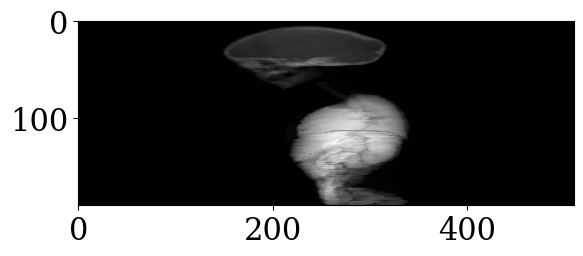

In [12]:
plt.imshow(phantom_np.sum(axis=2)[::-1], cmap='gray')

convert from labels to LAC values, need to first match up the provided labels with those in XCIST

https://github.com/xcist/main/tree/master/catsim/material

In [13]:
df = pd.read_csv("pediatric_phantom_data/labels.dat")
df

,Label,Organs
0,0,Air
1,1,Muscle
2,2,Bone
3,8,Stomach-Interior
4,21,Cartilage
5,38,Brain
6,226,Bladder
7,218,Gallbladder
8,180,Heart
9,222,Kidneys-right


In [14]:
materials_dict = {
    'Air': ['air', -1000],
    'Muscle' : ['ICRU_muscle_adult', 55],
    'Bone' : ['CIRS_bone_10yo', 300],
    'Stomach-Interior': ['ncat_intestine', 10],
    'Cartilage': ['ncat_cartilage', 200],
    'Brain': ['ncat_brain', 45],
    'Bladder' : ['ncat_bladder', 15],
    'Gallbladder' : ['ncat_adipose', 15], #approximation, gall typicaller darker than liver
    'Heart' : ['ncat_heart', 55],
    'Kidneys-right' : ['ncat_kidney', 45],
    'Kidneys-left' : ['ncat_kidney', 45],
    'Small-Intestine' : ['ncat_intestine', 10],
    'Large-Intestine' : ['ncat_intestine', 10],
    'Liver' : ['ncat_liver', 60],
    'Lung-right' : ['ncat_lung', -700],
    'Lung-left' : ['ncat_lung', -700],
    'Pancreas' : ['ncat_pancreas', 40],
    'Spleen' : ['ncat_spleen', 50],
    'Stomach' : ['ncat_intestine', 55],
    'Thymus' : ['ncat_lymph', 10],
    'Eyes-right': ['ncat_water', 0],
    'Eyes-left': ['ncat_water', 0],
    'Skull': ['ncat_skull', 500],
    'Trachea': ['ncat_cartilage', 200]
}

In [15]:
for material in df['Organs']:
  label = int(df[df['Organs'] == material]['Label'])
  phantom_np[phantom_np == label] = materials_dict[material][1]

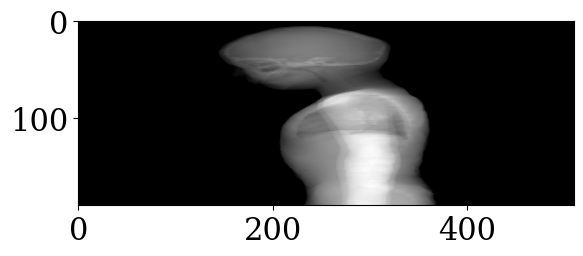

In [16]:
plt.imshow(phantom_np.sum(axis=2)[::-1], cmap='gray')

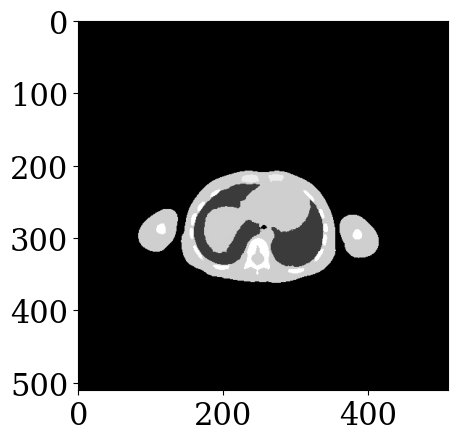

In [17]:
slice_idx = 75
img_slice = phantom_np[slice_idx]
plt.imshow(img_slice, cmap='gray')

Now export to Dicom

In [18]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.6 MB/s eta 0:00:00


In [19]:
from pydicom import dcmread, dcmwrite
from pydicom.data import get_testdata_file
fpath = get_testdata_file("CT_small.dcm")
ds = dcmread(fpath)

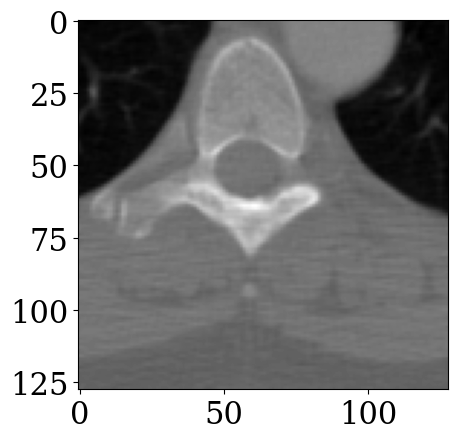

In [20]:
plt.imshow(ds.pixel_array, cmap='gray')

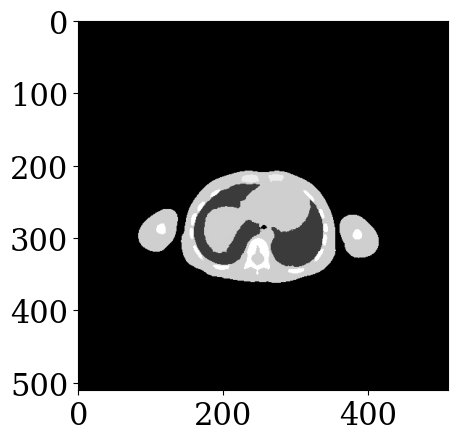

In [21]:
ds.Rows, ds.Columns = img_slice.shape
ds.PixelData = img_slice.tobytes()
plt.imshow(ds.pixel_array, cmap='gray')

In [22]:
ds.Rows

511

In [23]:
from pathlib import Path
phantom_path = Path('pediatric_phantom_data')
sample_slice_dcm = phantom_path / f'sample_slice_{slice_idx:03d}.dcm'
dcmwrite(sample_slice_dcm, ds)

In [24]:
materials = [materials_dict[m][0] for m in materials_dict]
thresholds = [materials_dict[m][1] for m in materials_dict]
materials, thresholds

(['air',
  'ICRU_muscle_adult',
  'CIRS_bone_10yo',
  'ncat_intestine',
  'ncat_cartilage',
  'ncat_brain',
  'ncat_bladder',
  'ncat_adipose',
  'ncat_heart',
  'ncat_kidney',
  'ncat_kidney',
  'ncat_intestine',
  'ncat_intestine',
  'ncat_liver',
  'ncat_lung',
  'ncat_lung',
  'ncat_pancreas',
  'ncat_spleen',
  'ncat_intestine',
  'ncat_lymph',
  'ncat_water',
  'ncat_water',
  'ncat_skull',
  'ncat_cartilage'],
 [-1000,
  55,
  300,
  10,
  200,
  45,
  15,
  15,
  55,
  45,
  45,
  10,
  10,
  60,
  -700,
  -700,
  40,
  50,
  55,
  10,
  0,
  0,
  500,
  200])

In [25]:
phantom_path

PosixPath('pediatric_phantom_data')

In [26]:
cfg_file_str = f"""
# Path where the DICOM images are located:
phantom.dicom_path = '{phantom_path}'
# Path where the phantom files are to be written (the last folder name will be the phantom files' base name):
phantom.phantom_path = '{phantom_path}/voxelized'
phantom.materials = {materials}
phantom.mu_energy = 63.948                  # Energy (keV) at which mu is to be calculated for all materials.
phantom.thresholds = {thresholds}		# Lower threshold (HU) for each material.
# phantom.slice_range = [[0,10]]			  # DICOM image numbers to include.
phantom.show_phantom = False                # Flag to turn on/off image display.
phantom.overwrite = True                   # Flag to overwrite existing files without warning.
"""

with open('dicom_to_voxelized.cfg', 'w') as f:
  f.write(cfg_file_str)

In [27]:
!cat dicom_to_voxelized.cfg


# Path where the DICOM images are located:
phantom.dicom_path = 'pediatric_phantom_data'          
# Path where the phantom files are to be written (the last folder name will be the phantom files' base name):
phantom.phantom_path = 'pediatric_phantom_data/voxelized'
phantom.materials = ['air', 'ICRU_muscle_adult', 'CIRS_bone_10yo', 'ncat_intestine', 'ncat_cartilage', 'ncat_brain', 'ncat_bladder', 'ncat_adipose', 'ncat_heart', 'ncat_kidney', 'ncat_kidney', 'ncat_intestine', 'ncat_intestine', 'ncat_liver', 'ncat_lung', 'ncat_lung', 'ncat_pancreas', 'ncat_spleen', 'ncat_intestine', 'ncat_lymph', 'ncat_water', 'ncat_water', 'ncat_skull', 'ncat_cartilage']
phantom.mu_energy = 63.948                  # Energy (keV) at which mu is to be calculated for all materials.
phantom.thresholds = [-1000, 55, 300, 10, 200, 45, 15, 15, 55, 45, 45, 10, 10, 60, -700, -700, 40, 50, 55, 10, 0, 0, 500, 200]		# Lower threshold (HU) for each material.
# phantom.slice_range = [[0,10]]			  # DICOM image numbers 

In [28]:
!wget https://raw.githubusercontent.com/bnel1201/XCIST_demo/main/DICOM_to_voxelized_phantom.py

--2023-06-13 03:25:23--  https://raw.githubusercontent.com/bnel1201/XCIST_demo/main/DICOM_to_voxelized_phantom.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22379 (22K) [text/plain]
Saving to: ‘DICOM_to_voxelized_phantom.py’

DICOM_to_voxelized_ 100%[===================>]  21.85K  --.-KB/s    in 0s      

2023-06-13 03:25:23 (102 MB/s) - ‘DICOM_to_voxelized_phantom.py’ saved [22379/22379]



In [29]:
!git clone https://github.com/xcist/main.git XCIST
!pip install XCIST/

Cloning into 'XCIST'...
remote: Enumerating objects: 3506, done.
remote: Counting objects: 100% (3506/3506), done.
remote: Compressing objects: 100% (1771/1771), done.
remote: Total 3506 (delta 1735), reused 3443 (delta 1701), pack-reused 0
Receiving objects: 100% (3506/3506), 275.94 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (1735/1735), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./XCIST
  Preparing metadata (setup.py) ... done
  Created wheel for catsim-xcist: filename=catsim_xcist-1.0.0-py3-none-any.whl size=10059457 sha256=17a703b31ae72e5d3930fe1a12f06c307e9d76d75a052b6dd647017c8e5315f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-s6i12l4j/wheels/98/95/ad/e6c6216330748f15fcd4f40eaea90ed0e79ae14cd27c47af89
Successfully built catsim-xcist


In [30]:
!python DICOM_to_voxelized_phantom.py dicom_to_voxelized.cfg

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['air', 'ncat_lung', 'ncat_lung', 'ncat_adipose', 'ncat_water', 'ncat_water', 'ncat_intestine', 'ncat_intestine', 'ncat_intestine', 'ncat_intestine', 'ncat_lymph', 'ncat_pancreas', 'ncat_brain', 'ncat_bladder', 'ICRU_muscle_adult', 'ncat_heart', 'ncat_kidney', 'ncat_kidney', 'ncat_liver', 'ncat_spleen', 'ncat_cartilage', 'ncat_cartilage', 'CIRS_bone_10yo', 'ncat_skull']
* mu values (/cm): [0.0, 0.05, 0.05, 0.18, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21,

## Now We Run the CT Experiment

In [31]:
import catsim as xc
import sys
from pathlib import Path

In [32]:
phantom_path

PosixPath('pediatric_phantom_data')

In [33]:
cfg_path = Path('cfg')
cfg_path.mkdir(exist_ok=True)
with open(cfg_path / 'Phantom_male_infant_ref.cfg', 'w') as f:
  f.write(f"""
# Phantom
phantom.callback = "Phantom_Voxelized"      # name of function that reads and models phantom
phantom.projectorCallback = "C_Projector_Voxelized"  # name of function that performs projection through phantom
phantom.filename = "{phantom_path}/voxelized/voxelized.json"   # phantom filename
phantom.centerOffset = [0.0, 0.0, 0.0]      # offset of phantom center relative to origin (in mm)
phantom.scale = 1.0
""")

In [34]:
with open(cfg_path / 'Physics_Default.cfg', 'w') as f:
  f.write("""
# Geometric and energy sampling
physics.energyCount = 20
physics.monochromatic = -1  # -1 for polychromatic (see protocol.cfg); for monoenergetic specify the energy in keV
physics.colSampleCount = 2
physics.rowSampleCount = 2
physics.srcXSampleCount = 2
physics.srcYSampleCount = 2
physics.viewSampleCount = 2

# Flags to determine what has to be recalculated each view
physics.recalcDet = 0
physics.recalcSrc = 0
physics.recalcRayAngle = 0
physics.recalcSpec = 0
physics.recalcFilt = 0
physics.recalcFlux = 0
physics.recalcPht = 0
physics.recalcDet = 0

# Noise on/off settings
physics.enableQuantumNoise = 1
physics.enableElectronicNoise = 1

# Internal physics models
physics.rayAngleCallback = "Detector_RayAngles_2D"
physics.fluxCallback = "Detection_Flux"
physics.scatterCallback = ""
physics.scatterKernelCallback = ""
physics.scatterScaleFactor = 1
physics.prefilterCallback = "Detection_prefilter"
physics.crosstalkCallback = ""
physics.lagCallback = ""
physics.opticalCrosstalkCallback = ""
physics.DASCallback = "Detection_DAS"

# I/O preferences
physics.outputCallback = "WriteRawView"
""")

In [35]:
with open(cfg_path / 'Protocol_Default.cfg', 'w') as f:
  f.write("""
protocol.scanTypes = [1, 1, 1]              # flags for airscan, offset scan, phantom scan

# Table and gantry
protocol.scanTrajectory = "Gantry_Helical"  # name of the function that defines the scanning trajectory and model
protocol.viewsPerRotation = 100            # total numbers of view per rotation
protocol.viewCount = 100                   # total number of views in scan
protocol.startViewId = 0                    # index of the first view in the scan
protocol.stopViewId = protocol.startViewId+protocol.viewCount-1 # index of the last view in the scan
protocol.airViewCount = 1                   # number of views averaged for air scan
protocol.offsetViewCount = 1                # number of views averaged for offset scan
protocol.rotationTime = 1.0                 # gantry rotation period (in seconds)
protocol.rotationDirection = 1              # gantry rotation direction (1=CW, -1 CCW, seen from table foot-end)
protocol.startAngle = 0                     # relative to vertical y-axis (n degrees)
protocol.tableSpeed = 0                     # speed of table translation along positive z-axis (in mm/sec)
protocol.startZ = 0                         # start z-position of table
protocol.tiltAngle = 0                      # gantry tilt angle towards negative z-axis (in degrees)
protocol.wobbleDistance = 0.0               # focalspot wobble distance
protocol.focalspotOffset = [0, 0, 0]        # focalspot position offset

# X-ray tube technique and filtration
protocol.mA = 200                           # tube current (in mA)
protocol.spectrumCallback = "Spectrum"      # name of function that reads and models the X-ray spectrum
protocol.spectrumFilename = "tungsten_tar7_120_unfilt.dat" # name of the spectrum file
protocol.spectrumScaling = 1                # scaling factor, works for both mono- and poly-chromatic spectra
protocol.spectrumUnit_mm = 0;               # Is the spectrum file in units of photons/sec/mm^2/<current>?
protocol.spectrumUnit_mA = 1;               # Is the spectrum file in units of photons/sec/<area>/mA?
protocol.bowtie = "small.txt"               # name of the bowtie file (or [] for no bowtie)
protocol.filterCallback = "Xray_Filter"     # name of function to compute additional filtration
protocol.flatFilter = ['Al',3.0]            # additional filtration - materials and thicknesses (in mm)
protocol.dutyRatio = 1.0                    # tube ON time fraction (for pulsed tubes)

# Pre- and Post-log processes
protocol.maxPrep = 9                        # set the upper limit of prep, can be used for simple low signal correction
""")

In [50]:
with open(cfg_path / 'Recon_Default.cfg', 'w') as f:
  f.write("""
recon.fov = 250.0                       # diameter of the reconstruction field-of-view (in mm)
recon.imageSize = 512                   # number of columns and rows to be reconstructed (square)
recon.sliceCount = 1                    # number of slices to reconstruct
recon.sliceThickness = 1.0              # reconstruction slice thickness AND inter-slice interval (in mm)
recon.centerOffset = [0.0, 0.0, 0.0]    # reconstruction offset relative to center of rotation (in mm)
recon.reconType = 'fdk_equiAngle'       # Name of the recon function to call
recon.kernelType = 'S-L'           # 'R-L' for the Ramachandran-Lakshminarayanan (R-L) filter, rectangular window function
                                        # 'S-L' for the Shepp-Logan (S-L) filter, sinc window function
                                        # 'Soft', 'Standard', 'Bone' for kernels similar to those on clinical scanners
recon.startAngle = 0                    # in degrees; 0 is with the X-ray source at the top
recon.unit = 'HU'                       # '/mm', '/cm', or 'HU'
recon.mu = 0.02059                        # in /mm; typically around 0.02/mm
recon.huOffset = -1000                  # unit is HU, -1000 HU by definition but sometimes something else is preferable
recon.printReconParameters = False      # Flag to print the recon parameters
recon.saveImageVolume = True            # Flag to save recon results as one big file
recon.saveSingleImages = False          # Flag to save recon results as individual imagesrecon.printReconParameters = False      # Flag to print the recon parameters
recon.displayImagePictures = False      # Flag to display the recon results as .png images
recon.saveImagePictureFiles = False     # Flag to save the recon results as .png images
recon.displayImagePictureAxes = False   # Flag to display the axes on the .png images
recon.displayImagePictureTitles = False # Flag to display the titles on the .png images
""")

In [37]:
with open(cfg_path / 'Scanner_Default', 'w') as f:
  f.write("""
# Scanner geometry
scanner.detectorCallback = "Detector_ThirdgenCurved" # name of function that defines the detector shape and model
scanner.sid = 540.0                         # source-to-iso distance (in mm)
scanner.sdd = 950.0                         # source-to-detector distance (in mm)
scanner.detectorColsPerMod = 1              # number of detector columns per module
scanner.detectorRowsPerMod = 16             # number of detector rows per module
scanner.detectorColOffset = 0.0             # detector column offset relative to centered position (in detector columns)
scanner.detectorRowOffset = 0.0             # detector row offset relative to centered position (in detector rows)
scanner.detectorColSize = 1.0               # detector column pitch or size (in mm)
scanner.detectorRowSize = 1.0               # detector row pitch or size (in mm)
scanner.detectorColCount = 900              # total number of detector columns
scanner.detectorRowCount = scanner.detectorRowsPerMod     # total number of detector rows
scanner.detectorPrefilter = ['graphite', 1.0]  # detector filter

# X-ray tube
scanner.focalspotCallback = "SetFocalspot"  # name of function that defines the focal spot shape and model
scanner.focalspotShape = "Uniform"          # Parameterize the model
scanner.targetAngle = 7.0                   # target angle relative to scanner XY-plane (in degrees)
scanner.focalspotWidth = 1.0
scanner.focalspotLength = 1.0

# Detector
scanner.detectorMaterial = "Lumex"          # detector sensor material
scanner.detectorDepth = 3.0                 # detector sensor depth (in mm)
scanner.detectionCallback = "Detection_EI"  # name of function that defines the detection process (conversion from X-rays to detector signal)
scanner.detectionGain = 17.0                # factor to convert energy to electrons (electrons / keV)
scanner.detectorColFillFraction = 0.9       # active fraction of each detector cell in the column direction
scanner.detectorRowFillFraction = 0.9       # active fraction of each detector cell in the row direction
scanner.eNoise = 3500.0                     # standard deviation of Gaussian electronic noise (in electrons)
""")

In [38]:
ct = xc.CatSim('cfg/Phantom_male_infant_ref',
               'cfg/Physics_Default',
               'cfg/Protocol_Default',
               'cfg/Recon_Default',
               'cfg/Scanner_Default')

In [39]:
ct.resultsName = 'male_infant_test'
ct.cfg.experimentDirectory = 'male_infant_test'

ct.cfg.do_Sim = False
ct.cfg.do_Recon = True
ct.cfg.recon.saveImagePictureFiles = True

# ct.protocol.viewsPerRotation = 2
# ct.protocol.viewCount = ct.protocol.viewsPerRotation
# ct.protocol.stopViewId = ct.protocol.viewCount-1

# ct.physics.enableQuantumNoise = 1
# ct.physics.enableElectronicNoise = 1

# ct.physics.colSampleCount = 2
# ct.physics.rowSampleCount = 2
# ct.physics.srcXSampleCount = 2
# ct.physics.srcYSampleCount = 2
# ct.physics.viewSampleCount = 1

In [40]:
ct.run_all()

Airscan
Scan sim time: 0.6 s
Offset scan
Scan sim time: 0.4 s
Phantom scan
phantom scan view loop...


100%|██████████| 100/100 [06:07<00:00,  3.68s/it]

Scan sim time: 369.0 s
Prep view
Simulation is done


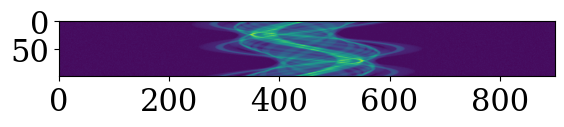

In [46]:
prep = xc.rawread(ct.resultsName+'.prep', [ct.protocol.viewCount, ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
prep = prep[:, 5, :]
plt.imshow(prep)

In [47]:
import reconstruction.pyfiles.recon as recon

In [48]:
ct.cfg.recon.displayImagePictures = True

* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


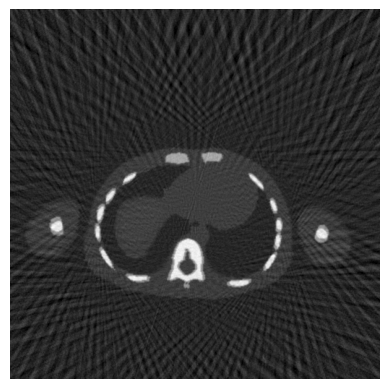

* Saving the recon results to individual .png files...


In [52]:
ct.cfg.waitForKeypress=False
ct.cfg.recon.fov = 250
recon.recon(ct.cfg)

In [45]:
prep = xc.rawread(ct.resultsName+'.scan', 2*[ct.recon.imageSize], 'float')
plt.imshow(prep)

ValueError: ignored